In [6]:
from pymongo import MongoClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import datetime
import time
import re
import random

def monthToInt(month):
    monthDict = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9, "October":10, "November":11, "December": 12 }
    return monthDict[month]

def dateToUnix(date):
    date = date.split(' ')
    try:
        year = int(date[-1])
        day = int(date[1][0:-1])
        month = monthToInt(date[0])
    except:
        year = 2013
        day = 11
        month = 11
    return time.mktime(datetime.datetime(year,month,day).timetuple())

def cleanAlch(alchItem):
    if ',' in alchItem:
        alchItem = ''.join(alchItem.split(','))
    if 'gp' in alchItem:
        return float(alchItem[0:-2])
    else:
        return float(alchItem[0:-1])*1000

def cleanPriceGP(price):
    if price=='':
        price=0
    else:
        price = re.sub('gp','',price)
        price = re.sub(',','',price)
    try:
        return long(price)
    except:
        return long(0)

def getRandomItemDF(dataset):
    randomItem = random.choice(np.unique(dataset['ItemName']))
    return dataset[dataset['ItemName'] == randomItem]

def getItemsInPriceRange(dataset,minVal,maxVal):
    theData = dataset[dataset.Price> minVal]#sometimes cuts off parts of item's data
    theData = theData[theData.Price< maxVal]
    theData = dataset[dataset['ItemName'].isin(np.unique(theData['ItemName']))]
    return theData

def getRecentSectionOfDataset(dataset,dateFloor):    
    recentData = dataset[dataset.PriceDate > dateFloor]
    return recentData

def cleanChangeInPrice(price):
    price = re.sub('\+','',price)
    price = re.sub(',','',price)
    price = re.sub('gp','',price)
    return price

In [7]:
mongodb = MongoClient().rsmarket

cursor = mongodb.items.find()

data = pd.DataFrame(list(cursor))
data['HighAlch'] = data['HighAlch'].map(cleanAlch)
data['LowAlch'] = data['LowAlch'].map(cleanAlch)
data['DateAdded'] = data['DateAdded'].map(dateToUnix)
data.head()

,Category,DateAdded,HighAlch,ItemName,LowAlch,MembersOnly,Prices,_id
0,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,"[[June 23, 2015, 1,523gp, -20gp], [June 13, 20...",558a6bcb049914cc5bad9112
1,Jewellery,1319439600,121200,Regen bracelet,80800,Yes,"[[June 23, 2015, 118,187gp, -2,918gp], [June 1...",558a6c16049914cc5bad9114
2,Ammo,1319439600,58,Mithril javelin,39,Yes,"[[June 23, 2015, 79gp, 0gp], [June 13, 2015, 8...",558a6c63049914cc5bad9116
3,Melee weapons - high level,1319439600,750000,Saradomin godsword,500000,Yes,"[[June 23, 2015, 11,351,267gp, +39,090gp], [Ju...",558a6cb6049914cc5bad9118
4,Miscellaneous,1381129200,0,Bond,0,No,"[[June 23, 2015, 9,608,173gp, +79,808gp], [Jun...",558a6d02049914cc5bad911a


In [8]:
dataframelist = []
for datum in range(len(data)):
    tempDF = pd.DataFrame(columns=(list(data.columns)+['PriceDate']+['Price']))
    i = len(data.iloc[datum]['Prices'])
    tempDF['_id'] = [data.iloc[datum]['_id']]*i
    tempDF['ItemName'] = [data.iloc[datum]['ItemName']]*i
    tempDF['DateAdded'] = ([data.iloc[datum]['DateAdded']]*i)
    tempDF['Category'] = [data.iloc[datum]['Category']]*i
    tempDF['MembersOnly'] = [data.iloc[datum]['MembersOnly']]*i
    tempDF['HighAlch'] = ([data.iloc[datum]['HighAlch']]*i)
    tempDF['LowAlch'] = ([data.iloc[datum]['LowAlch']]*i)
    tempDF['PriceDate'] = ([dateToUnix(k[0]) for k in data.iloc[datum]['Prices']])
    tempDF['Price'] = ([cleanPriceGP(k[1]) for k in data.iloc[datum]['Prices']])
    tempDF['PriceChange'] = ([cleanChangeInPrice(k[2]) for k in data.iloc[datum]['Prices']])
    del tempDF['Prices']
    dataframelist.append(tempDF)

In [9]:
fullData = pd.DataFrame(columns=(list(data.columns)+['PriceDate']+['Price']))

fullData = pd.concat([fullData]+dataframelist)

del fullData['Prices']
del fullData['_id']

categoryEncoder = LabelEncoder()
fullData['Category'] = categoryEncoder.fit_transform(fullData['Category'])
itemNameEncoder = LabelEncoder()
fullData['ItemName'] = itemNameEncoder.fit_transform(fullData['ItemName'])
membersOnlyEncoder = LabelEncoder()
fullData['MembersOnly'] = membersOnlyEncoder.fit_transform(fullData['MembersOnly'])

fullData = fullData[fullData.Price!=0]

print len(fullData)
fullData.head()

3695772


,Category,DateAdded,HighAlch,ItemName,LowAlch,MembersOnly,Price,PriceChange,PriceDate
0,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,1523,-20,1435042800
1,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,1538,-30,1434178800
2,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,1543,0,1434956400
3,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,1568,0,1434092400
4,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,1543,-24,1434870000


In [10]:
cols = fullData.columns.tolist()
cols = [cols[-1]]+cols[0:6]+[cols[7]]+[cols[6]]
fullData[cols].head()
fullData = fullData[cols]
fullData.head()

,PriceDate,Category,DateAdded,HighAlch,ItemName,LowAlch,MembersOnly,PriceChange,Price
0,1435042800,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,-20,1523
1,1434178800,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,-30,1538
2,1434956400,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,0,1543
3,1434092400,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,0,1568
4,1434870000,Miscellaneous,1319439600,600,Bagged plant 1,400,Yes,-24,1543


In [11]:
print 'before dropping duplicates: ',len(fullData)
fullData = fullData.drop_duplicates()
print 'after: ',len(fullData)

before dropping duplicates:  3695772
after:  3541613


In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()

onehot.fit_transform(fullData['ItemName'])

In [77]:
junefirst = 1430438400

recentFullData = getRecentSectionOfDataset(fullData,junefirst)

lowPricedData = getItemsInPriceRange(fullData,300,1000)
recentLowPricedData = getRecentSectionOfDataset(lowPricedData,junefirst)

lowMedPricedData = getItemsInPriceRange(fullData,1000,5000)
recentLowMedPricedData = getRecentSectionOfDataset(lowMedPricedData,junefirst)

mediumPricedData = getItemsInPriceRange(fullData,5000,20000)
recentMediumPricedData = getRecentSectionOfDataset(mediumPricedData,junefirst)

richPricedData = getItemsInPriceRange(fullData,1000000,5000000)
recentRichPricedData = getRecentSectionOfDataset(richPricedData,junefirst)

In [165]:
kfolds = KFold(len(X), n_folds=5, shuffle=True, random_state=np.random.RandomState())

scores = cross_val_score(RandomForestRegressor(n_estimators=15),X,y,cv=kfolds,n_jobs=-1)
print "Accuracy: ",scores.mean()," Std: ",scores.std()

Accuracy:  0.998035415576  Std:  0.00158676120415


In [82]:
#this is for predicting and graphing
X = fullData[fullData.columns[0:-2]]
y = fullData['Price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=15,n_jobs=-1)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.999334572331537

Recent Price:  1407.0


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


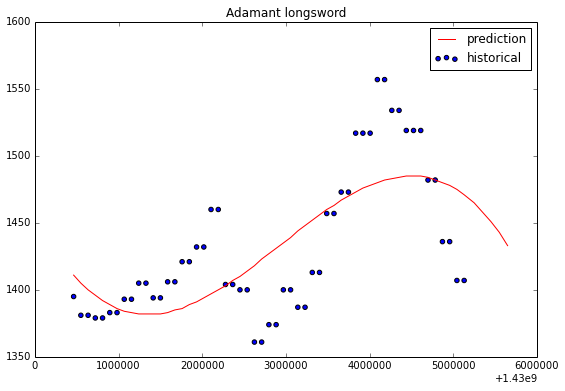

In [84]:
item = getRandomItemDF(recentFullData)

X = item[item.columns[0:-1]]
y = item['Price']

model = make_pipeline(PolynomialFeatures(degree=15),Ridge())
model.fit(X,y)

plt.figure(figsize=(9,6))
plt.scatter(item['PriceDate'],item['Price'],c='b',label='historical')
plt.title(itemNameEncoder.classes_[item.iloc[0]['ItemName']])

print 'Recent Price: ',item[item['PriceDate']==max(item['PriceDate'])].iloc[0]['Price']

dates = sorted(item['PriceDate'])+[1435248710+increment for increment in range(0,500000,100000)]

preds = []

for i in dates:
    nextPred = item.iloc[0]
    nextPred['PriceDate']=i
    pricePred = int(model.predict(nextPred[0:-1]))
    preds.append(pricePred)

plt.plot(dates,preds,c='r',label='prediction')
plt.legend()
plt.show()